# 0.0 IMPORTS

In [1]:
import pandas as pd
import inflection
import math
import numpy as np

import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import HTML
from IPython.display import Image

## 0.1. Helper functions

In [197]:
# setting seaborn style
sns.set_style("darkgrid")
sns.set_palette("Accent")

# setting matplolit inline
%matplotlib inline

# set max columns do be displayed
pd.set_option("display.max_columns", 100)

## 0.2 Loading dada

In [3]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [4]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
249500,35,3,2014-12-17,14445,909,1,1,0,0,d,c,7660.0,10.0,2000.0,1,1.0,2012.0,"Jan,Apr,Jul,Oct"


# 1.0 DATA DESCRIPTION

Let's take a look at data field descriptions from Kaggle.

https://www.kaggle.com/c/rossmann-store-sales/data

**Data fields**

Most of the fields are self-explanatory. The following are descriptions for those that aren't.

- **Id** - an Id that represents a (Store, Date) duple within the test set
- **Store** - a unique Id for each store
- **Sales** - the turnover for any given day (this is what you are predicting)
- **Customers** - the number of customers on a given day
- **Open** - an indicator for whether the store was open: 0 = closed, 1 = open
- **StateHoliday** - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
- **SchoolHoliday** - indicates if the (Store, Date) was affected by the closure of public schools
- **StoreType** - differentiates between 4 different store models: a, b, c, d
- **Assortment** - describes an assortment level: a = basic, b = extra, c = extended
- **CompetitionDistance** - distance in meters to the nearest competitor store
- **CompetitionOpenSince[Month/Year]** - gives the approximate year and month of the time the nearest competitor was opened
- **Promo** - indicates whether a store is running a promo on that day
- **Promo2** - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- **Promo2Since[Year/Week]** - describes the year and calendar week when the store started participating in Promo2
- **PromoInterval** - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [5]:
# make a copy from original DataFrame, so we can separate the dataset manipulation by section
df1 = df_raw.copy()

## 1.1. Rename columns
Rename columns to make easier to understand and work with them.

In [6]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [7]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 
            'SchoolHoliday', 'StoreType', 'Assortment','CompetitionDistance', 'CompetitionOpenSinceMonth', 
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

# snake_case
snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

# rename
df1.columns = cols_new

In [8]:
# verifying the operations
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2.  Data dimensions
Verify the number of rows and columns in the dataset.

In [9]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of cols: {}'.format(df1.shape[1]))

Number of rows: 1017209
Number of cols: 18


## 1.3.  Data types
Verifying the dataset data types.

In [10]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [11]:
# transforming 'date' column to datetime type
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4.  Check NaN
Verifying presence of missing values.

In [12]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

We noticed that we have a lot of missing data. We can one of the following three paths:

**1) Exclude all lines that have missing data**, but we may lose important information that the ML algorithm may need and negatively impact the forecasting.

**2) Use ML techniques to fill in the missing data** and predict what value would be replace `NaN`. This method is good when we don't have business information available.

**3) Really understand the business.** Understand the business rules and fill in the missing data with relevant information.

## 1.5.  Fillout NA
We chose the method 3 (understand the business).

In [13]:
# observing the maximum distance to the nearest competitor
df1['competition_distance'].max()

75860.0

In [14]:
# competition_distance
# let's assume that the distance from competitors is so long that there are no competitors
# applying for each column record: competition_distance
#     assign 200000.0 if record == NaN ; assign its current value if record != NaN
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

# competition_open_since_month
# let's assume that the opening date is the store date: date
# axis=1 -> apply in the row along the columns, because we have more than one column in the expression
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

# competition_open_since_year 
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

# promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

In [15]:
# promo_interval

# creating dictionary that will help in mapping
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
             7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

# fill in the NaN with zeroes
df1['promo_interval'].fillna(0, inplace=True)

# creating the 'month_map' column as the month mapping of the 'date' column
df1['month_map'] = df1['date'].dt.month.map(month_map)

In [16]:
df1.sample(5).T

,850579,170455,775511,670438,651939
store,620,976,257,1109,450
day_of_week,4,7,1,5,7
date,2013-05-30 00:00:00,2015-03-01 00:00:00,2013-08-05 00:00:00,2013-11-08 00:00:00,2013-11-24 00:00:00
sales,0,0,6192,4989,0
customers,0,0,714,474,0
open,0,0,1,1,0
promo,1,0,0,1,0
state_holiday,a,0,0,0,0
school_holiday,1,0,0,0,0
store_type,d,a,a,c,c


In [17]:
# make a split in 'promo_interval' column and creates a list containing the values
# check if the value of 'month_map' is within that list
# creates column 'is_promo' with numeric values (1 = was in promo or 0 = was not in promo) based on the verification
df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [18]:
df1.sample(5).T

,938882,830472,718222,625848,684721
store,838,583,948,4,897
day_of_week,2,1,4,2,6
date,2013-03-12 00:00:00,2013-06-17 00:00:00,2013-09-26 00:00:00,2013-12-17 00:00:00,2013-10-26 00:00:00
sales,4876,6797,5854,14471,17298
customers,592,642,1475,1791,413
open,1,1,1,1,1
promo,0,1,1,1,0
state_holiday,0,0,0,0,0
school_holiday,0,0,0,0,0
store_type,d,a,b,c,c


In [19]:
# verificando operações
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6.  Change types

In [20]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

We notice that the following columns are `float64`:
- `competition_open_since_month`
- `competition_open_since_year`
- `promo2_since_week` 
- `promo2_since_year` 

However, they are actually `int` values as the represent months and years which are discrete values. Thus, we can do:

In [21]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [22]:
# checking the operations
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7. Descriptive Statistics

It is through the descriptive statistics that we get a notion from the business. 

It helps detect some errors

Two big metrics: distribution and central tendency

Central tendency: summary statistics, median, mean

We need to know how the data is distributed around the median and mean.

Skew and kurtosis.

Check how vars behave. Negative values that shouldn't

In [23]:
# creating a dataset for numerical attributes
num_attributes = df1.select_dtypes(include=['int64','float64'])

# creating a dataset for categorical attributes
cat_attributes = df1.select_dtypes(exclude=['int64','float64', 'datetime64[ns]'])

In [24]:
# checking the operation
num_attributes.sample(2)

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
536977,333,5,10200,1304,1,1,1,3720.0,2,2010,0,10,2014,0
260778,105,5,7000,700,1,1,0,6190.0,12,2014,1,23,2013,1


In [25]:
# checking the operation
cat_attributes.sample(2)

,state_holiday,store_type,assortment,promo_interval,month_map
711617,0,a,a,0,Oct
398484,0,a,c,0,Jul


### 1.7.1 Numerical attributes

In [26]:
# central tendency: mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# distribution: std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']

In [27]:
# checking the operations
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


#### Plotting distribution for `sales`

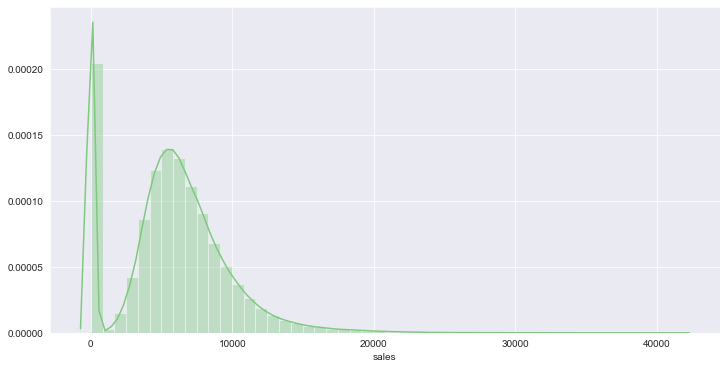

In [28]:
ax = sns.distplot(df1['sales'])

# setting the figure size in inches
ax.figure.set_size_inches(12, 6)

# display plot
plt.show()

#### Plotting distribution for `competition_distance`

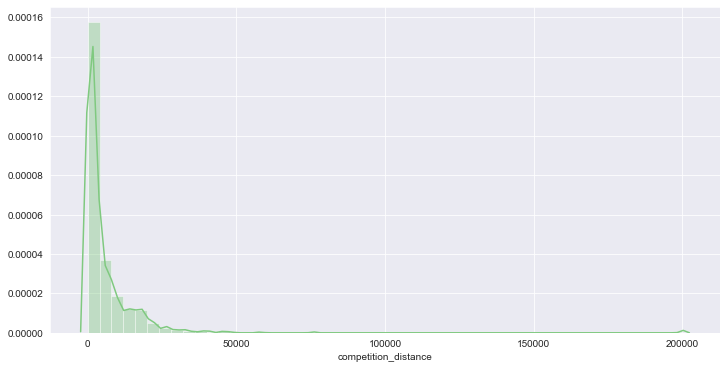

In [29]:
ax = sns.distplot(df1['competition_distance'])

# setting the figure size in inches
ax.figure.set_size_inches(12, 6)

# display plot
plt.show()

#### Using pandas.describe

In [30]:
num_attributes.describe().T

,count,mean,std,min,25%,50%,75%,max
store,1017209.0,558.429727,321.908651,1.0,280.0,558.0,838.0,1115.0
day_of_week,1017209.0,3.998341,1.997391,1.0,2.0,4.0,6.0,7.0
sales,1017209.0,5773.818972,3849.926175,0.0,3727.0,5744.0,7856.0,41551.0
customers,1017209.0,633.145946,464.411734,0.0,405.0,609.0,837.0,7388.0
open,1017209.0,0.830107,0.375539,0.0,1.0,1.0,1.0,1.0
promo,1017209.0,0.381515,0.485759,0.0,0.0,0.0,1.0,1.0
school_holiday,1017209.0,0.178647,0.383056,0.0,0.0,0.0,0.0,1.0
competition_distance,1017209.0,5935.442677,12547.652996,20.0,710.0,2330.0,6910.0,200000.0
competition_open_since_month,1017209.0,6.786849,3.311087,1.0,4.0,7.0,10.0,12.0
competition_open_since_year,1017209.0,2010.324840,5.515593,1900.0,2008.0,2012.0,2014.0,2015.0


### 1.7.1 Categorical attributes

In [31]:
# check how many types we have for each atribute
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

#### Plotting boxplots for `state_holiday`, `store_type` and `assortment` in relation to `sales`

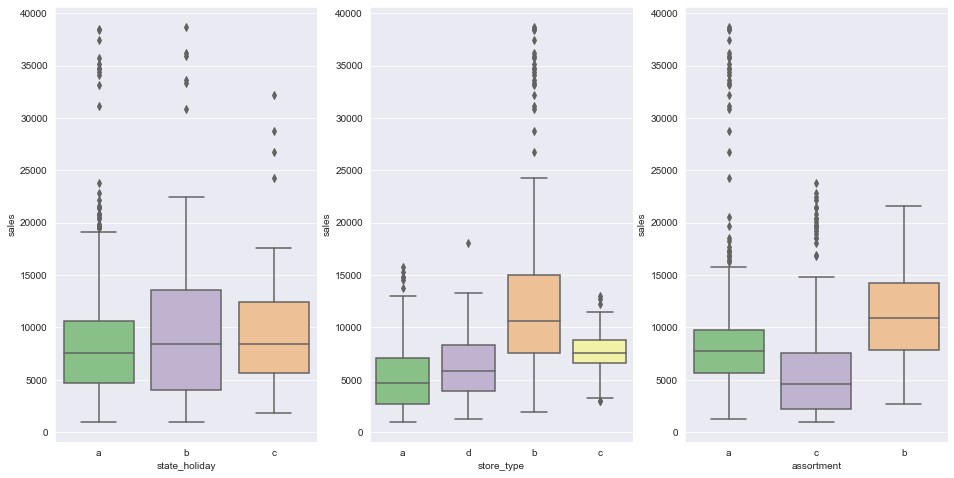

In [32]:
# filtering the data that we want to display
# as we don't want to see all the days on which the stores were closed
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

# using the variable ax for single a Axes
fig, ax = plt.subplots()

# setting the figure size in inches
ax.figure.set_size_inches(16, 8)

plt.subplot(1, 3, 1)
ax = sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 3, 2)
ax = sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1, 3, 3)
ax = sns.boxplot(x='assortment', y='sales', data=aux1)

# display plot
plt.show()

# 2.0 FEATURE ENGINEERING

### 2.0.1 Project Checkpoint
Let's save our progress and make a checkpoint in our project by making a copy of `df1`. So we don't have to run everything from the start. We can start from here.

In [33]:
# copying df1 to df2
df2 = df1.copy()

## 2.1 Hypothesis Mindmap
In real life, we draw the mindmap with the stakeholders in a brainstorm-like meeting.

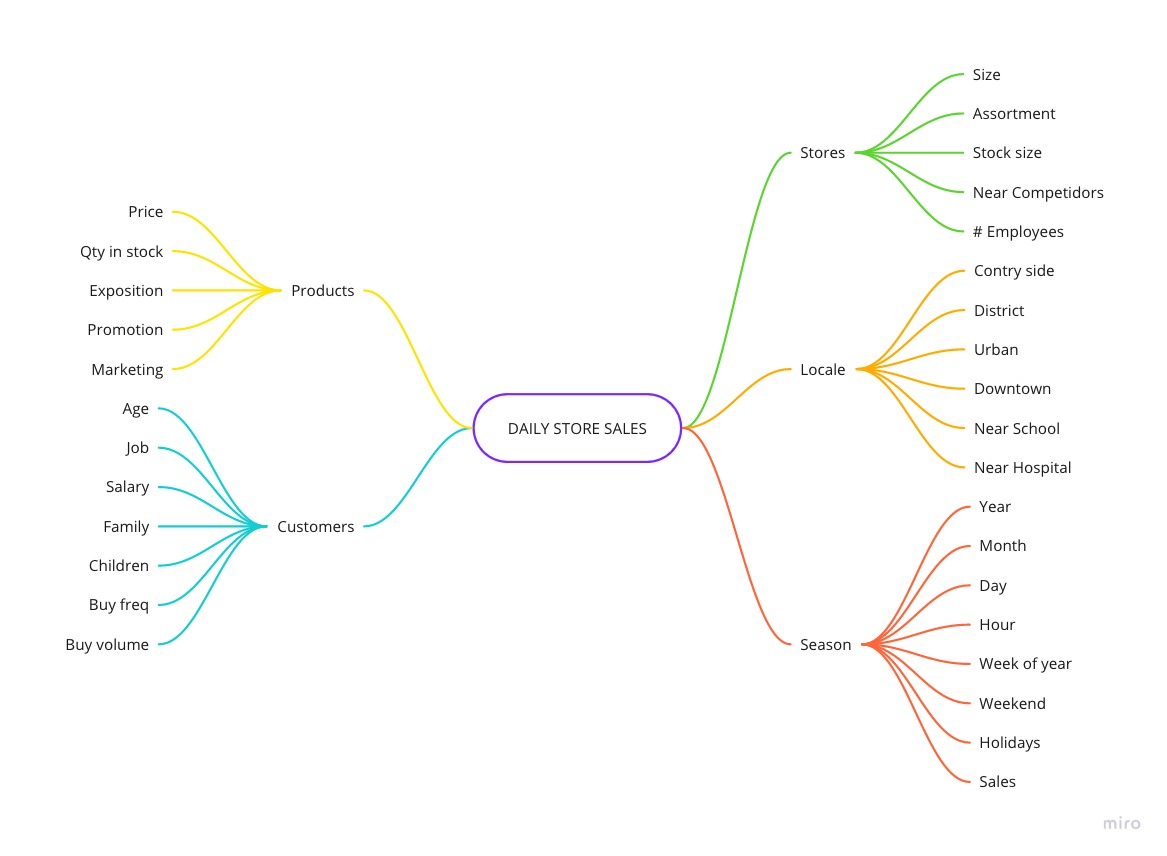

In [195]:
# displaying the mindmap
Image('img/hypothesis_map.png')

## 2.2 Creating hypothesis

Creating hypothesis for each variable that you believe that impact in the phenomenon that we are studying, in this case, **Daily Store Sales**, and relate each variable's attributes with the phenomenon.

In real life, we outline the hypothesis in a brainstorm-like meeting with the stakeholders.

### 2.2.1 Store Hypothesis

**1.** Stores with higher number of employees should have higher sales.

**2.** Stores with higher stock should should have higher sales.

**3.** Stores with higher size should should have higher sales.

**4.** Stores with lesser size should have lesser sales.

**5.** Stores with higher assortment should should have higher sales.

**6.** Stores with nearer competitors should have lesser sales.

**7.** Stores with longer competitors should have higher sales.

### 2.2.2 Product Hypothesis

**1.** Stores with higher investments in marketing should have higher sales.

**2.** Stores with higher product exposure should should have higher sales.

**3.** Stores with lesser product prices should should have higher sales.

**4.** Stores with higher discount values should should have higher sales.

**5.** Stores with lesser product prices for longer period of time should should have higher sales.

**6.** Stores with longer period of time in promotion should have higher sales.

**7.** Stores with higher consecutive promotions should have higher sales.

### 2.2.3 Season Hypothesis

**1.** Stores that open on Xmas should have higher sales. 

**2.** Stores should have higher sales along the year.

**3.** Stores should have higher sales on the second semester of the year.

**4.** Stores should have higher sales after the 10th day of the month.

**5.** Stores should have higher sales on weekends.

**6.** Stores should have higher sales during school holidays.

## 2.3 Prioritized hypothesis list
We prioritize the hypothesis based on: whether we have or not the data at hand.

There may be data that we don't have it at hand and we need to spend some time on accessing it, collecting it, cleaning it and analyzing it.

**Store**

**1.** Stores with higher assortment should have higher sales.

**2.** Stores with nearer competitors should have lesser sales.

**3.** Stores with longer competitors should have higher sales.

<br>

**Product**

**4.** Stores with lesser product prices for longer period of time should have higher sales.

**5.** Stores with longer period of time in promotion should have higher sales.

**6.** Stores with higher consecutive promotions should have higher sales.

<br>

**Season**

**7.** Stores that open on Xmas should have higher sales. 

**8.** Stores should have higher sales along the year.

**9.** Stores should have higher sales on the second semester of the year.

**10.** Stores should have higher sales after the 10th day of the month.

**11.** Stores should have higher sales on weekends.

**12.** Stores should have higher sales during school holidays.

## 2.4 Feature engineering - de facto
In this section, we are going to create some variables (columns) in our dataset to make easier do explore the dataset in the EDA phase.

In [35]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

In [36]:
# checking the operations
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,0,0,0,0,0
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


In [37]:
# competition since

# creating a new datetime column 'competition_since' which is a compound of two columns
# we are specifying that it will always have the 1st day of the month
df2['competition_since'] = df2.apply(lambda x: 
                                     datetime.datetime(year=x['competition_open_since_year'], 
                                                                 month=x['competition_open_since_month'], 
                                                                 day=1), 
                                     axis=1)

In [38]:
# checking the operations
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,0,0,0,0,0
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


In [39]:
# How many months has passed since the competition store opened?
# getting the difference between columns and divding it by 30 to make the monthly granularity
#     then we get the days as int type
df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype(int)

In [40]:
# checking the operations
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,0,0,0,0,0
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


In [41]:
# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' +df2['promo2_since_week'].astype(str)

# converting values from 'promo_since' to datetime considering 7 days
df2['promo_since'] = df2['promo_since'].apply(lambda x: 
                         datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))

# How many weeks has passed since the promotion started?
# OR for how long (in weeks) the promotion is active?
# getting the difference between columns and divding it by 7 to make the weekly granularity
#     then we get the days as int type
df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days).astype(int)

In [42]:
# checking the operations
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,0,0,0,0,0
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


In [43]:
# assortment
# replacing the values to make easier to understand them
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
# replacing the values to make easier to understand them
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

In [44]:
# checking the operations
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 VARIABLE FILTERING

### 3.0.1 Project Checkpoint
Let's save our progress and make a checkpoint in our project by making a copy of `df2`. So we don't have to run everything from the start. We can start from here.

In [45]:
# copying df2 to df3
df3 = df2.copy()

In [46]:
# checking the dataset
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1 Row filtering
We're going to filter the rows first, because the performance is better when fltering the columns later. There are less data to process.

As it makes no sense to get data from closed stores (`open = 0`), we'll consider only the rows where `open = 1` which is the same as saying `'open' != 0`.

As closed stores have 0 sales, we'll consider only the sales from open stores (`open = 1`), that is, `'sales' > 0`.

In [47]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Column filtering

We don't have the number of `customers` at the moment of the prediction. We would need other ML model to predict it and use it here. The scope of this project will not consider the customers, so we'll classify it as a business restriction.

In the previous step, as we filtered only the rows where `open = 1`, it makes no sense to keep the column `open` because it has only values equal to `1`.

Also, the columns `promo_interval` and `month_map` were only used to derive other columns. Thus, we don't need them anymore.

In [48]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']

# dropping the columns
df3 = df3.drop(cols_drop, axis=1)

In [49]:
# checking the operation
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 EXPLORATORY DATA ANALYSIS

### 4.0.1 Project Checkpoint
Let's save our progress and make a checkpoint in our project by making a copy of `df3`. So we don't have to run everything from the start. We can start from here.

In [50]:
# copying df3 to df4
df4 = df3.copy()

In [51]:
# checking dataset
df4.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 4.1 Univariate analysis

### 4.1.1 Target variable

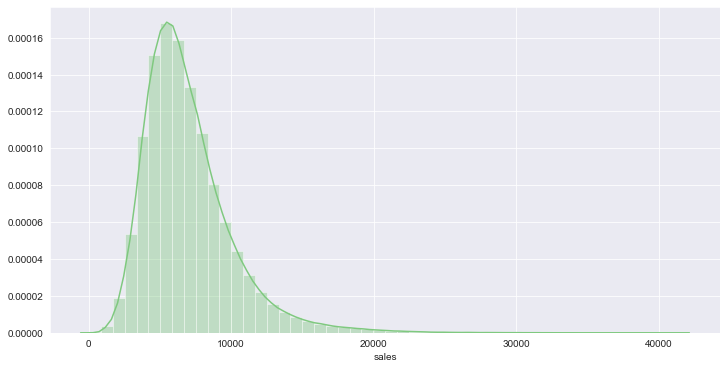

In [54]:
# distribution plotting for 'sales'
ax = sns.distplot(df4['sales'])

# setting the figure size in inches
ax.figure.set_size_inches(12, 6)

# display plot
plt.show()

As we can observe, the distribution is skewed and presents a kurtosis. Thus, the distribution does not follow a normal distribution.

As the ML algorithms requires our data to have independent variables and normal distribution, we can apply some techniques to do the variable transformation.

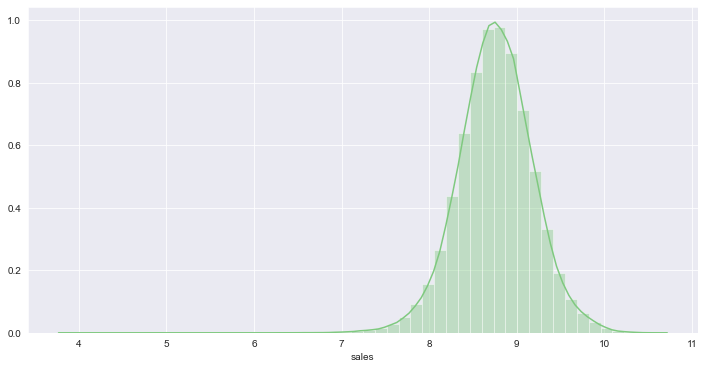

In [55]:
# distribution plotting for 'sales'
# applying log(x + 1) to 'sales'
ax = sns.distplot(np.log1p(df4['sales']))

# setting the figure size in inches
ax.figure.set_size_inches(12, 6)

# display plot
plt.show()

### 4.1.2 Numerical variable (TO DO = Seaborn multi var hist plot)

<ipython-input-72-35f2cde529d7>:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  num_attributes.hist(ax=ax, bins=25);


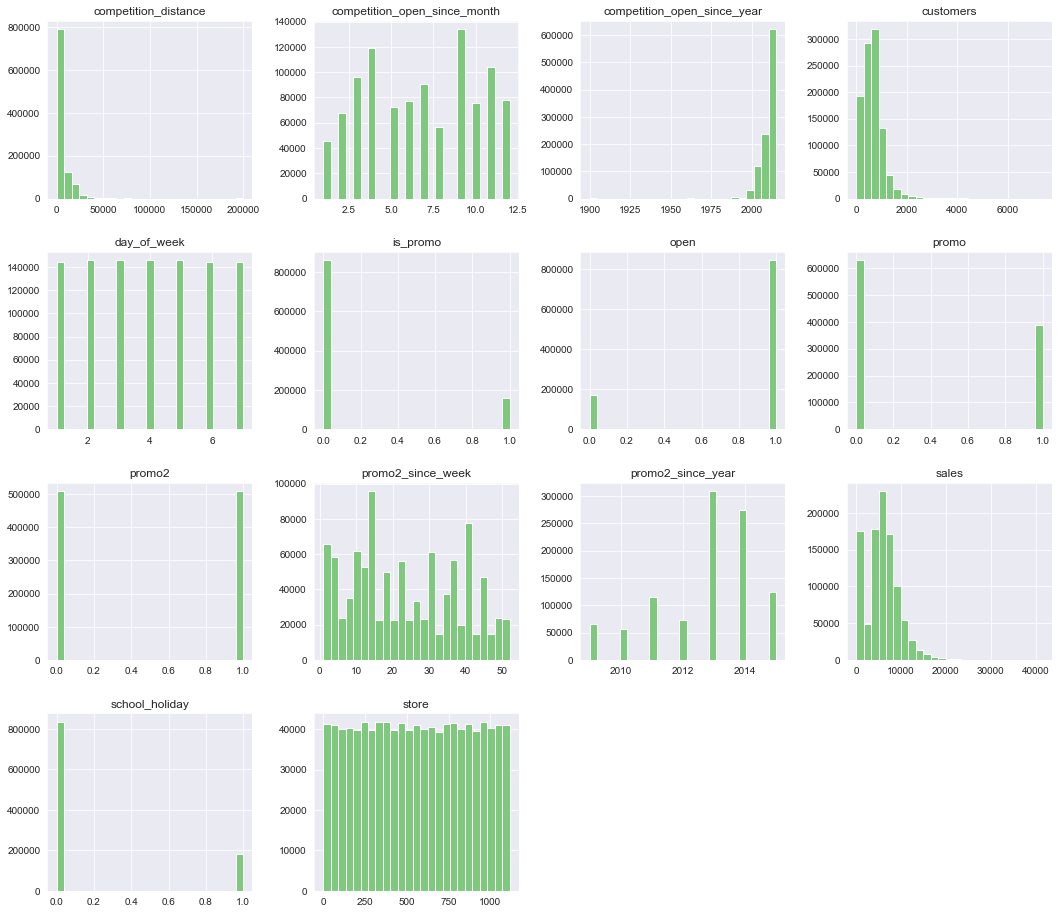

In [72]:
fig = plt.figure(figsize = (18,16))

ax = fig.gca()

num_attributes.hist(ax=ax, bins=25);

Analyzing the histograms, for:
- `competition_distance`: we have more competitors that are near the stores, as they gather in the range from 0 to near 50000. 
- `competition_since_month`: 
- `day_of_week`: we have a distribution that is nearly uniform, this tells us that the sales nearly don't vary according to the day of the week. Thus, this variable, alone, doesn't have much relevance to the model.
- `is_promo`: we have higher sales when there is no promotion (`is_promo = 0`) than when we have (`is_promo = 1`).


### 4.1.1 Categorical variable

In [73]:
# checking the categorical variables
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


In [74]:
# checking the kind of 'state_holiday' we have in the dataset
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

In [75]:
df4['state_holiday'].unique()

array(['regular_day', 'public_holiday', 'easter_holiday', 'christmas'],
      dtype=object)

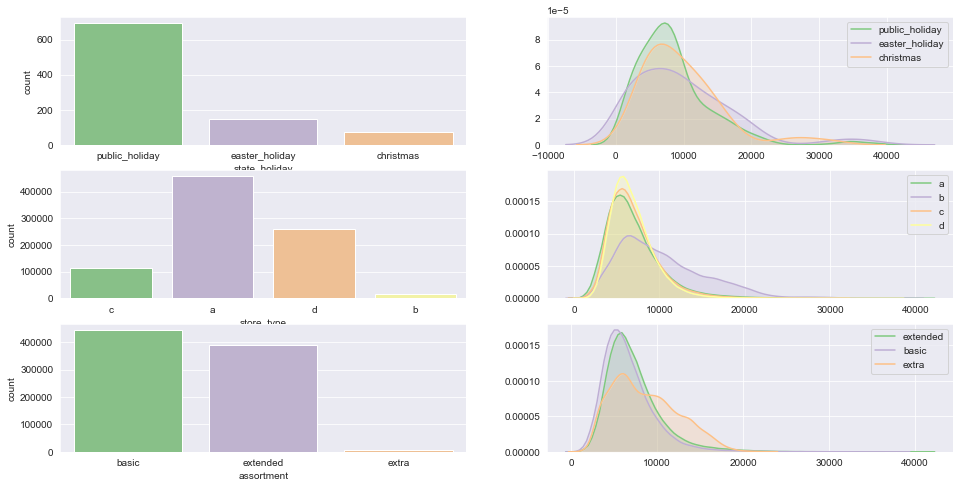

In [88]:
# using the variable ax for single a Axes
fig, ax = plt.subplots()

# setting the figure size in inches
ax.figure.set_size_inches(16, 8)

# state_holiday
plt.subplot(3,2,1)
a = df4[df4['state_holiday'] != 'regular_day']
ax = sns.countplot(a['state_holiday'])

plt.subplot(3,2,2)
ax = sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
ax = sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
ax = sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)


# store_type
plt.subplot(3,2,3)
ax = sns.countplot(df4['store_type'])

plt.subplot(3,2,4)
ax = sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
ax = sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
ax = sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
ax = sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)

# assortment
plt.subplot(3,2,5)
ax = sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
ax = sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
ax = sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
ax = sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True)


# display plots
plt.show()

## 4.2 Bivariate analysis

In [198]:
df4.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


### H1. Stores with higher assortment should have higher sales.

In [147]:
# checking total sales for each 'assortment' type
aux1 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()
aux1

,assortment,sales
0,basic,2945750070
1,extended,2856484241
2,extra,70946312


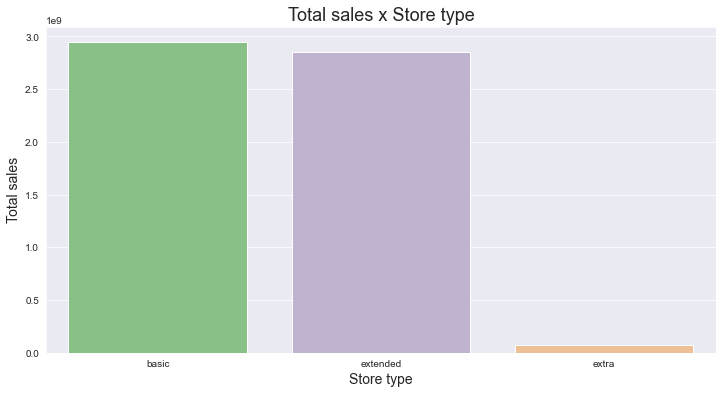

In [148]:
# using the variable ax for single a Axes
fig, ax = plt.subplots()

# setting the figure size in inches
ax.figure.set_size_inches(12, 6)

ax = sns.barplot(x='assortment', y='sales', data=aux1)

# setting the title and axis labels
ax.set_title("Total sales x Store type", fontsize=18)
ax.set_xlabel("Store type", fontsize=14)
ax.set_ylabel("Total sales", fontsize=14)

# display plot
plt.show()

We are assuming that stores that have higher assortment are classified as type `extra`. Thus, observing the barplot, we can verify that stores with **lesser assortment (`basic`) have higher sales**.

In other words, **stores with higher assortment have lesser sales**.

However, we need to check if in the past, stores with higher assortment had higher sales.

In [149]:
# checking each assortment sales 
aux2 = df4[['year_week', 'assortment','sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2

,year_week,assortment,sales
0,2013-00,basic,13434262
1,2013-00,extended,12425669
2,2013-00,extra,269404
3,2013-01,basic,26007250
4,2013-01,extended,22917693
...,...,...,...
406,2015-29,extended,19570832
407,2015-29,extra,574020
408,2015-30,basic,23492454
409,2015-30,extended,23301780


In [150]:
# creating a pivot table
aux3 = aux2.pivot(index='year_week', columns='assortment', values='sales')
aux3

assortment,basic,extended,extra
year_week,,,
2013-00,13434262,12425669,269404
2013-01,26007250,22917693,350279
2013-02,17970974,16029584,377207
2013-03,24392076,21243431,404662
2013-04,19972891,18130077,363061
...,...,...,...
2015-26,27840342,27165959,684180
2015-27,20356210,20449036,586036
2015-28,25746704,25629698,632017


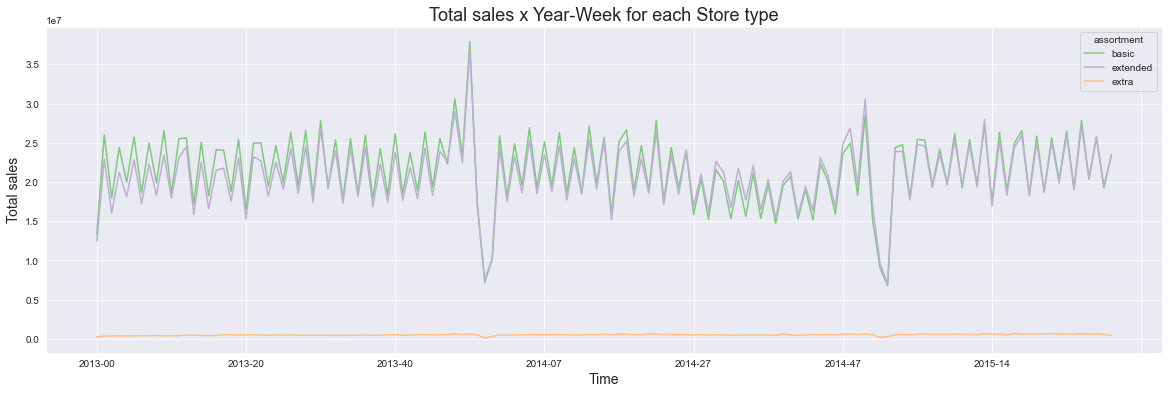

In [151]:
# plotting a lineplot for 'aux3'
ax = aux3.plot()

# setting the figure size in inches
ax.figure.set_size_inches(20, 6)

# setting the title and axis labels
ax.set_title("Total sales x Year-Week for each Store type", fontsize=18)
ax.set_xlabel("Time", fontsize=14)
ax.set_ylabel("Total sales", fontsize=14)

# display the plot
plt.show()

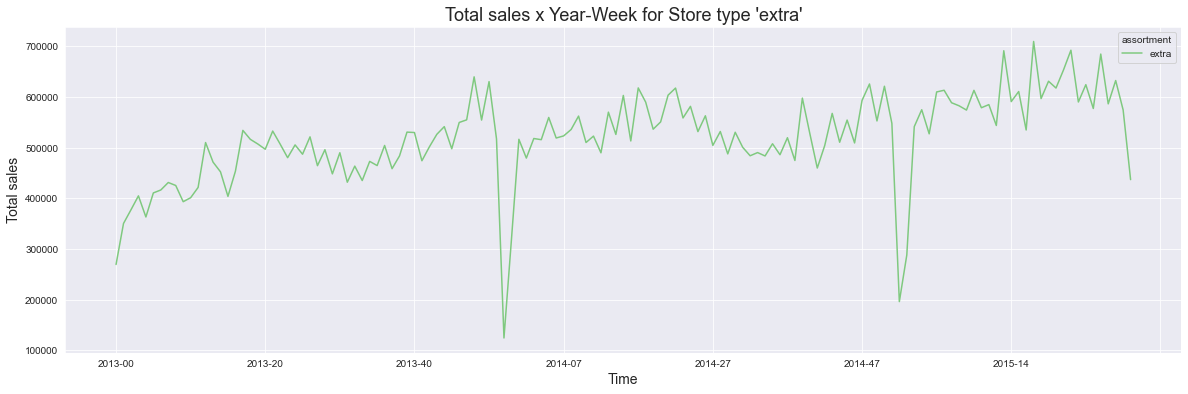

In [152]:
# filtering for only 'extra' type of assortment
aux3 = aux2[aux2['assortment'] == 'extra']

# plotting a lineplot for 'aux3'
ax = aux3.pivot(index='year_week', columns='assortment', values='sales').plot()

# setting the figure size in inches
ax.figure.set_size_inches(20, 6)

# setting the title and axis labels
ax.set_title("Total sales x Year-Week for Store type 'extra'", fontsize=18)
ax.set_xlabel("Time", fontsize=14)
ax.set_ylabel("Total sales", fontsize=14)

# display the plot
plt.show()

Observing the line plots, we can verify that **stores with higher assortment (`extra`) have lesses sales**. So, our hypothesis is **FALSE**.

### H2. Stores with nearer competitors should have lesser sales.

In [153]:
# checking total sales for each 'competition_distance'
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()
aux1

,competition_distance,sales
0,20.0,4579807
1,30.0,17552666
2,40.0,29261626
3,50.0,60835848
4,60.0,22088359
...,...,...
650,46590.0,3554993
651,48330.0,3798660
652,58260.0,5718883
653,75860.0,6896821


In [154]:
# creating bins that range from 0 to 20000 with steps of 1000
bins = list (np.arange(0, 20000, 1000))

# placing the data in the bins
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)

aux1.sample(10)

,competition_distance,sales,competition_distance_binned
89,970.0,14864537,"(0.0, 1000.0]"
226,2740.0,10722029,"(2000.0, 3000.0]"
627,26990.0,6654188,NaN
332,4630.0,4885211,"(4000.0, 5000.0]"
273,3450.0,7856819,"(3000.0, 4000.0]"
163,1870.0,14863112,"(1000.0, 2000.0]"
366,5440.0,4835283,"(5000.0, 6000.0]"
262,3300.0,5068030,"(3000.0, 4000.0]"
50,520.0,20204286,"(0.0, 1000.0]"
608,21790.0,7069345,NaN


In [155]:
# getting the total sales for each bin
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()
aux2

,competition_distance_binned,sales
0,"(0, 1000]",1832415839
1,"(1000, 2000]",918682669
2,"(2000, 3000]",610405362
3,"(3000, 4000]",378745560
4,"(4000, 5000]",325665741
5,"(5000, 6000]",218735915
6,"(6000, 7000]",168769215
7,"(7000, 8000]",133211838
8,"(8000, 9000]",180027950
9,"(9000, 10000]",121250715


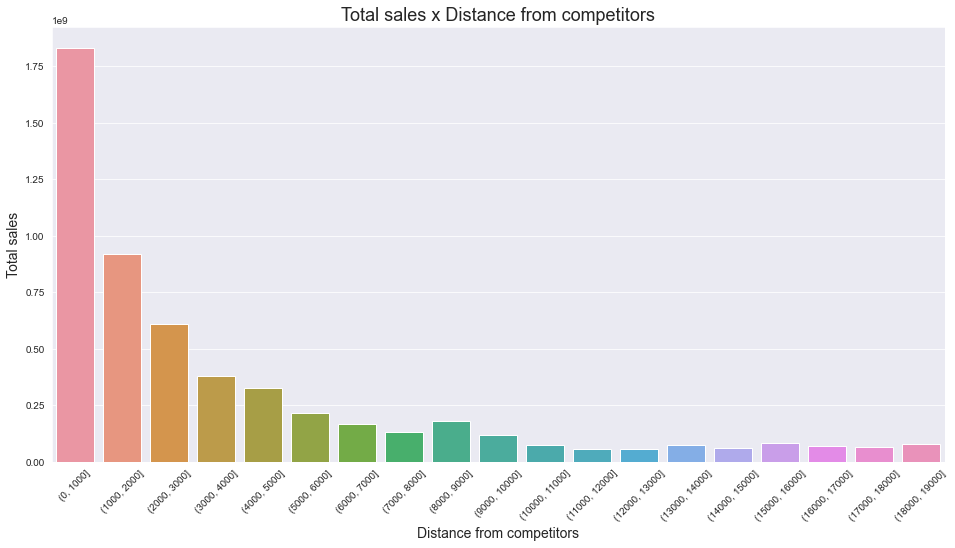

In [156]:
# using the variable ax for single a Axes
fig, ax = plt.subplots()

# setting the figure size in inches
ax.figure.set_size_inches(16, 8)

# plotting a barplot for 'aux2'
ax = sns.barplot(x='competition_distance_binned', y='sales', data=aux2)

# rotate xlabels
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# setting the title and axis labels
ax.set_title("Total sales x Distance from competitors", fontsize=18)
ax.set_xlabel("Distance from competitors", fontsize=14)
ax.set_ylabel("Total sales", fontsize=14)

plt.show()

As we can observe from the barplot, **stores with nearer competitors have higher sales**. So, our hypothesis is **FALSE**.

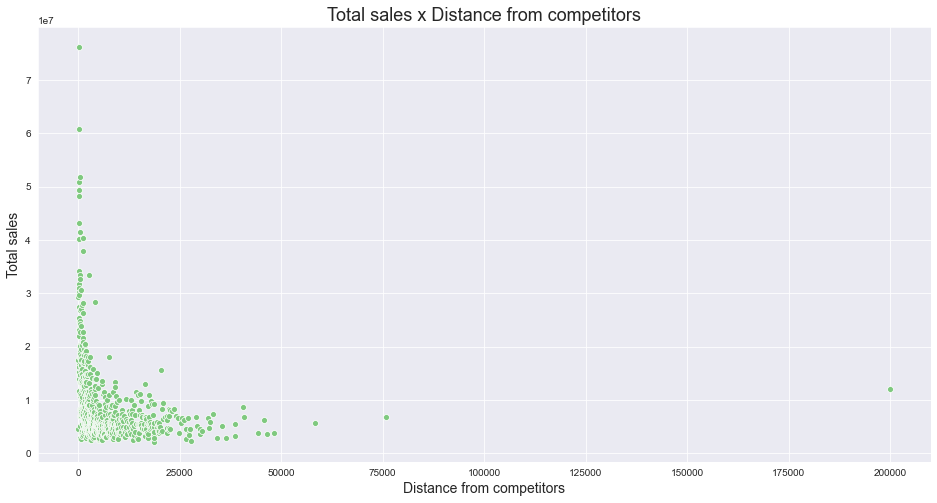

In [157]:
# checking total sales for each 'competition_distance'
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

# using the variable ax for single a Axes
fig, ax = plt.subplots()

# setting the figure size in inches
ax.figure.set_size_inches(16, 8)

# plotting a scatter plot for sales in relation to competition_distance
sns.scatterplot(x='competition_distance', y='sales', data=aux1)

# setting the title and axis labels
ax.set_title("Total sales x Distance from competitors", fontsize=18)
ax.set_xlabel("Distance from competitors", fontsize=14)
ax.set_ylabel("Total sales", fontsize=14)

plt.show()

We can observe from the scatter plot that we have a higher concentration of sales as we descrease the competition distance, which also makes our hypothesis **FALSE**.

#### Organizing the plots in a single grid

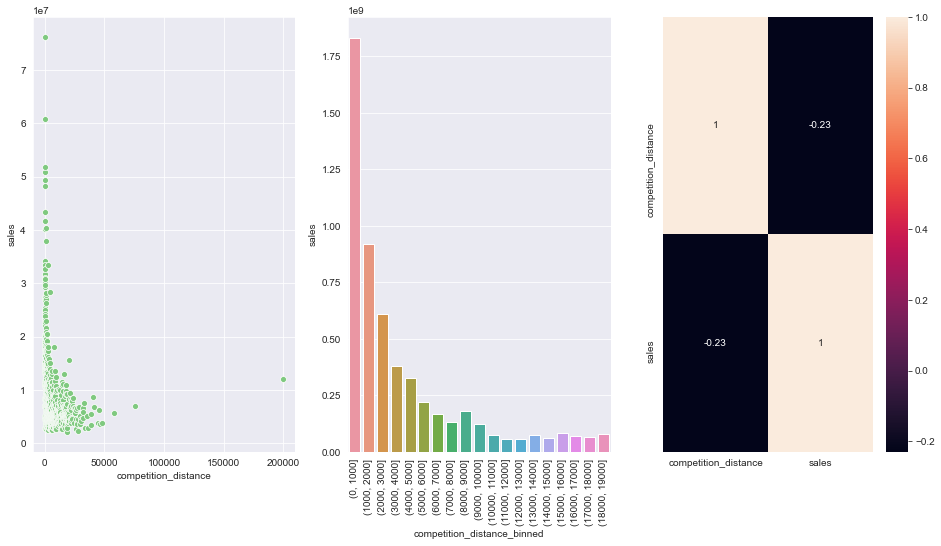

In [164]:
# using the variable ax for single a Axes
fig, ax = plt.subplots()

# setting the figure size in inches
ax.figure.set_size_inches(16, 8)

plt.subplot(1, 3, 1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1)

plt.subplot(1, 3, 2)
ax = sns.barplot(x='competition_distance_binned', y='sales', data=aux2)

# rotate xlabels
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### H3. Stores with longer competitors should have higher sales.

We want to know how do our `sales` behave in relation to how long a competitor store has opened.

In [188]:
# getting all sales by months since the a competition store opened
aux1 = df4[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index()

# get only the 120 months AND opened in the same month of the sale
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]

aux2

,competition_time_month,sales
0,-32,198200
1,-31,993663
2,-30,2232685
3,-29,3175827
4,-28,4157527
...,...,...
147,115,15655375
148,116,15784105
149,117,15658505
150,118,14428150


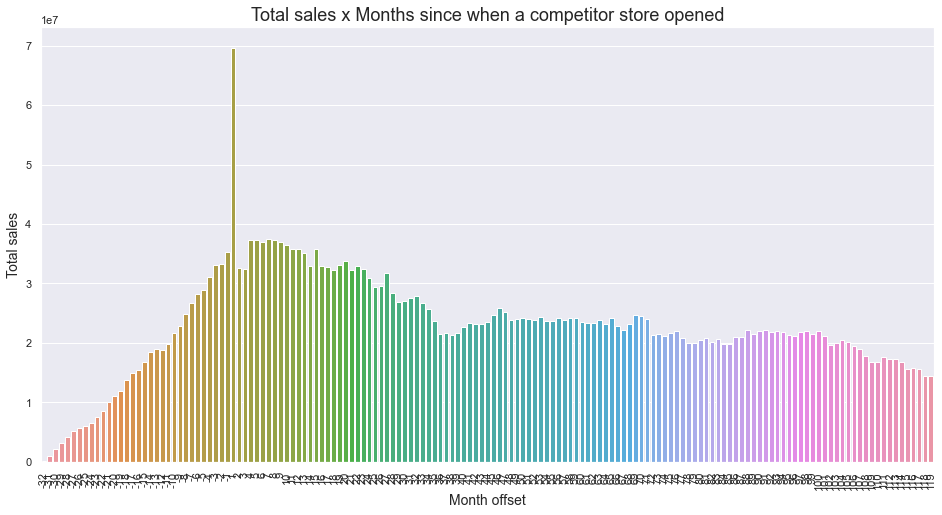

In [189]:
# using the variable ax for single a Axes
fig, ax = plt.subplots()

# setting the figure size in inches
ax.figure.set_size_inches(16, 8)

# plotting a barplot for 'aux2'
ax = sns.barplot(x='competition_time_month', y='sales', data=aux2)

# rotating the xticks
plt.xticks(rotation=90)

# setting the title and axis labels
ax.set_title("Total sales x Months since when a competitor store opened", fontsize=18)
ax.set_xlabel("Month offset", fontsize=14)
ax.set_ylabel("Total sales", fontsize=14)

# display plot
plt.show()

- **Negative offset values:** we already started selling and we know when a competitor store will still open in x months. 
- **Positive offset values:** competitor store has already opened and we started selling.

As values gets near zero the higher are the sales. **The earlier the competition is, the higher the sales are.** Thus, our hypothesis is **FALSE**.

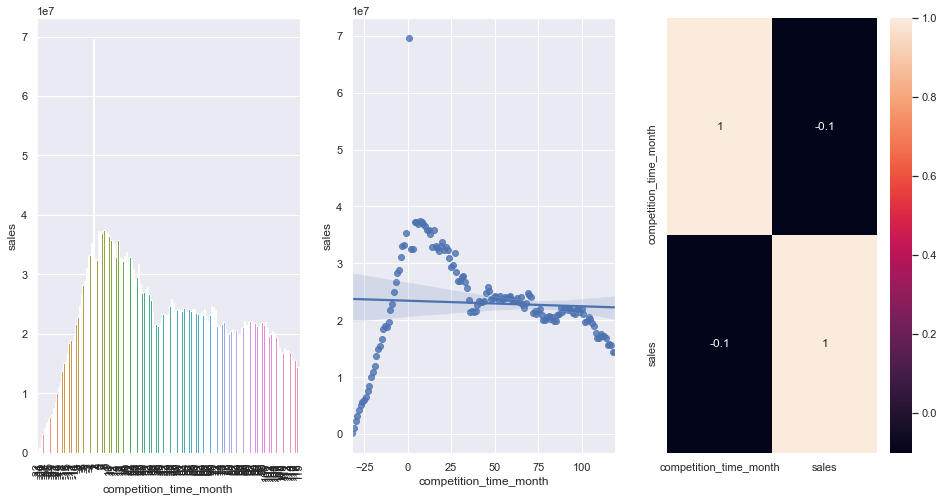

In [194]:
# using the variable ax for single a Axes
fig, ax = plt.subplots()

# setting the figure size in inches
ax.figure.set_size_inches(16, 8)

plt.subplot(1, 3, 1)
# plotting a barplot
sns.barplot(x='competition_time_month', y='sales', data=aux2)

# rotating the xticks
plt.xticks(rotation=90)

plt.subplot(1, 3, 2)
# plotting a regplot
sns.regplot(x='competition_time_month', y='sales', data=aux2)

plt.subplot(1, 3, 3)
# plotting a heatmap
sns.heatmap(aux1.corr(method='pearson'), annot=True)

# display plot
plt.show()

As the Pearson coefficient is `-0.1` it tells us that the variable `competition_time_month` is relevant for our model.

### H4. Stores with lesser product prices for longer period of time should have higher sales.

In [199]:
# getting how many sales based on how long a promotion was active
aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()
aux1

,promo_time_week,sales
0,-126,80706
1,-125,147212
2,-124,107127
3,-123,140121
4,-122,116593
...,...,...
435,309,360433
436,310,277156
437,311,353546
438,312,268970


- `promotime_week > 0`: sales made inside the **extended** promotion time.
- `promotime_week < 0`: sale made inside the **regular** promotion time.

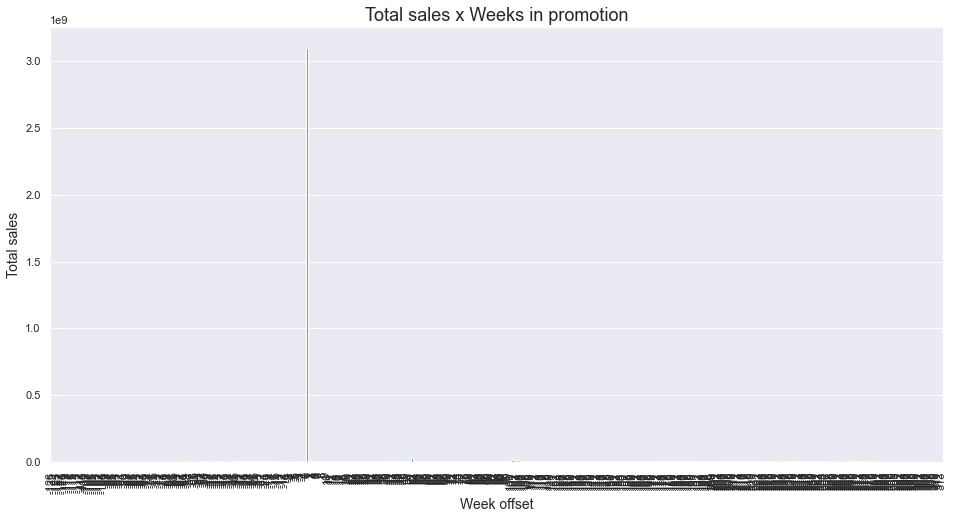

In [200]:
# using the variable ax for single a Axes
fig, ax = plt.subplots()

# setting the figure size in inches
ax.figure.set_size_inches(16, 8)

# plotting a barplot
ax = sns.barplot(x='promo_time_week', y='sales', data=aux1)

# rotating the xticks
plt.xticks(rotation=90)

# setting the title and axis labels
ax.set_title("Total sales x Weeks in promotion", fontsize=18)
ax.set_xlabel("Week offset", fontsize=14)
ax.set_ylabel("Total sales", fontsize=14)

# display plot
plt.show()

As we observe in the bar plot, we can't see anything because there are loads of data. So, let's divide our data in two periods: **regular promotion and extended promotion**.

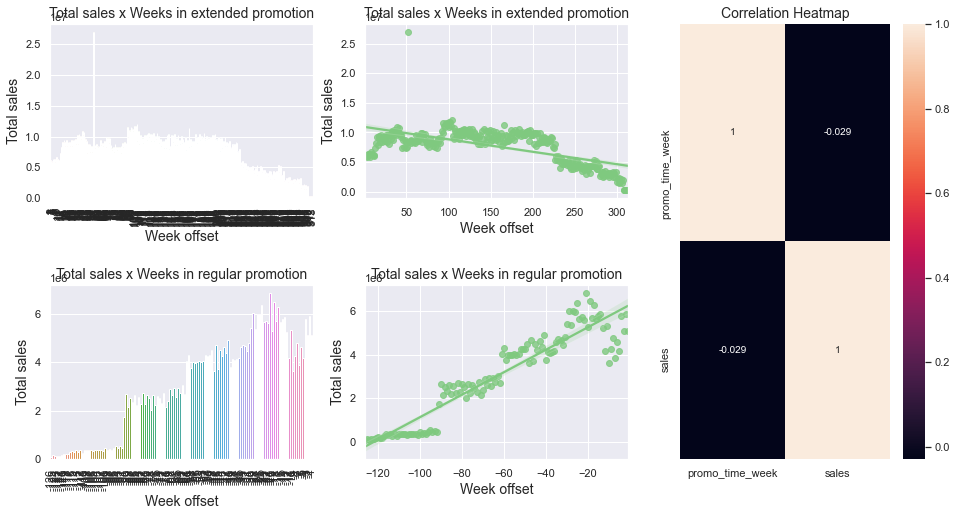

In [233]:
from matplotlib.gridspec import GridSpec

# using the variable ax for single a Axes
fig, ax = plt.subplots()

grid = GridSpec(2, 3)

# adjusting the space between subplots
plt.subplots_adjust(hspace = 0.5)

# setting the figure size in inches
ax.figure.set_size_inches(16, 8)

# getting the extended promo data
aux2 = aux1[aux1['promo_time_week'] > 0] 

# plotting a barplot
plt.subplot(grid[0, 0])
ax1 = sns.barplot(x='promo_time_week', y='sales', data=aux2);

# setting the title and axis labels
ax1.set_title("Total sales x Weeks in extended promotion", fontsize=14)
ax1.set_xlabel("Week offset", fontsize=14)
ax1.set_ylabel("Total sales", fontsize=14)

# rotating the xticks
plt.xticks(rotation=90)

# plotting a regplot
plt.subplot(grid[0, 1])
ax2 = sns.regplot(x='promo_time_week', y='sales', data=aux2);

# setting the title and axis labels
ax2.set_title("Total sales x Weeks in extended promotion", fontsize=14)
ax2.set_xlabel("Week offset", fontsize=14)
ax2.set_ylabel("Total sales", fontsize=14)

# getting the regular promo data
aux3 = aux1[aux1['promo_time_week'] < 0]

# plotting a barplot
plt.subplot(grid[1, 0])
ax3 = sns.barplot(x='promo_time_week', y='sales', data=aux3);

# setting the title and axis labels
ax3.set_title("Total sales x Weeks in regular promotion", fontsize=14)
ax3.set_xlabel("Week offset", fontsize=14)
ax3.set_ylabel("Total sales", fontsize=14)

# rotating the xticks
plt.xticks(rotation=90)


# plotting a regplot
plt.subplot(grid[1, 1])
ax4 = sns.regplot(x='promo_time_week', y='sales', data=aux3);

# setting the title and axis labels
ax4.set_title("Total sales x Weeks in regular promotion", fontsize=14)
ax4.set_xlabel("Week offset", fontsize=14)
ax4.set_ylabel("Total sales", fontsize=14)


# plotting correlation heatmap
plt.subplot(grid[:,2])
ax5 = sns.heatmap(aux1.corr(method='pearson'), annot=True)

# setting the title
ax5.set_title("Correlation Heatmap", fontsize=14)


# display plot
plt.show()

As we can observe in the **Total sales x Weeks in extended promotion**, there's a period in which the extended promotion results in more sales, then after a period of time, the total sales starts to drecrease.

From the **Total sales x Weeks in regular promotion**, we can observe that as the offset gets more and more near zero, the sales starts to increase.

Thus, **stores with lesser product prices for longer period of time don't have higher sales**, because the sales start to drecrease as the promotion gets longer. 

Thus, our hypothesis is **FALSE**.

In addition, from the **Correlation Heatmap** we got a coefficient of `-0.029` which is pretty close to `zero`. Thus, we have a **weak correlation**, which makes sense because looking at our data, we have long periods of almost constant total sales (see  **Total sales x Weeks in extended promotion**).

So, maybe we won't include `promo_time_week` in the model. Of course, this variable might work if we combine it with another variable, but we'll leave it for the time being.

### H5. Stores with longer period of time in promotion should have higher sales.

As this hypothesis is similar to H4. We'll leave to validate it in the next CRISP cycle.

### H6. Stores with higher consecutive promotions should have higher sales.

In [234]:
# Getting how many sales were made based on promotion and consecutive promotions
df4[['promo','promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


Observing the results, there were more sales when there was only a promotion (`promo = 1` AND `promo2 = 0`) than when there were consecutive promotions (`promo = 1` AND `promo2 = 1`).

In [236]:
# getting all rows in which there were consecutive promotions
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux1

,year_week,sales
0,2013-01,20995409
1,2013-03,19481514
2,2013-05,20580811
3,2013-07,20273185
4,2013-09,21451952
...,...,...
67,2015-22,21069133
68,2015-24,22839486
69,2015-26,23972605
70,2015-28,21867757


In [246]:
aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2

,year_week,sales
0,2013-01,22118270
1,2013-03,20567037
2,2013-05,22087889
3,2013-07,21631750
4,2013-09,22727171
...,...,...
67,2015-22,23590590
68,2015-24,23635449
69,2015-26,25394352
70,2015-28,23393262


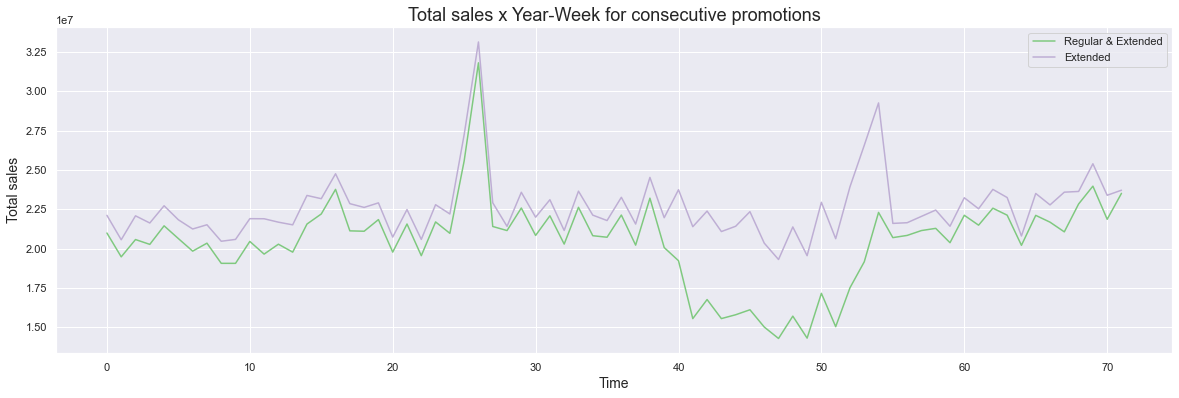

In [247]:
# plotting a lineplot
ax = aux1.plot()

# plotting in the same grid
aux2.plot(ax = ax)

# setting the figure size in inches
ax.figure.set_size_inches(20, 6)

# setting the title and axis labels
ax.set_title("Total sales x Year-Week for consecutive promotions", fontsize=18)
ax.set_xlabel("Time", fontsize=14)
ax.set_ylabel("Total sales", fontsize=14)

ax.legend(labels=['Regular & Extended', 'Extended'])

# display the plot
plt.show()

Observing the results it seems that **stores with higher consecutive promotions don't have higher sales**. Thus, our hypothesis is **FALSE**.

Thinking about the relevance of the variable `promo2` to the ML model, we can say that its relevance is low. Despite the particular decrease in sales during a period, we still need a second opinion that will come from an algorithm that will aid us to decide wether we include `promo2` or not.

## 4.3 Multivariate analysis